In [361]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from time import sleep
import selenium
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from riotwatcher import LolWatcher, ApiError
import riotwatcher
import stylecloud
from IPython.display import Image
from os import remove


# SCRAPPING CON LA API DE RIOT

In [362]:
api_key = 'RGAPI-7dd815dd-27c0-4e02-8c36-cf94c45f9bde'
watcher = LolWatcher(api_key)
my_region = 'euw1'

In [363]:
versions = watcher.data_dragon.versions_for_region(my_region)
champions_version = versions['n']['champion']
current_champ_list = watcher.data_dragon.champions(champions_version, full = True)
current_champ_list['data']['Aatrox']['tags'][1]

'Tank'

In [364]:
lista_final = []
for i in current_champ_list['data']:
    campeon = [current_champ_list['data'][i]['name'],current_champ_list['data'][i]['lore'], current_champ_list['data'][i]['tags'][0]]
    if len(current_champ_list['data'][i]['tags']) > 1:
        campeon.append(current_champ_list['data'][i]['tags'][1])
    else:
        campeon.append('Missing')
    lista_final.append(campeon)
lista_final

[['Aatrox',
  'Once honored defenders of Shurima against the Void, Aatrox and his brethren would eventually become an even greater threat to Runeterra, and were defeated only by cunning mortal sorcery. But after centuries of imprisonment, Aatrox was the first to find freedom once more, corrupting and transforming those foolish enough to try and wield the magical weapon that contained his essence. Now, with stolen flesh, he walks Runeterra in a brutal approximation of his previous form, seeking an apocalyptic and long overdue vengeance.',
  'Fighter',
  'Tank'],
 ['Ahri',
  'Innately connected to the latent power of Runeterra, Ahri is a vastaya who can reshape magic into orbs of raw energy. She revels in toying with her prey by manipulating their emotions before devouring their life essence. Despite her predatory nature, Ahri retains a sense of empathy as she receives flashes of memory from each soul she consumes.',
  'Mage',
  'Assassin'],
 ['Akali',
  'Abandoning the Kinkou Order and 

# EDA Y LIMPIEZA DE DATOS

In [365]:
# Vamos a tokenizar cada lore

for i in lista_final:
    i[1] = nltk.word_tokenize(i[1],"english")

In [366]:
lore_completo = ''
for i in lista_final:
    lore_completo+=' '.join(i[1])
lore_completo

"Once honored defenders of Shurima against the Void , Aatrox and his brethren would eventually become an even greater threat to Runeterra , and were defeated only by cunning mortal sorcery . But after centuries of imprisonment , Aatrox was the first to find freedom once more , corrupting and transforming those foolish enough to try and wield the magical weapon that contained his essence . Now , with stolen flesh , he walks Runeterra in a brutal approximation of his previous form , seeking an apocalyptic and long overdue vengeance .Innately connected to the latent power of Runeterra , Ahri is a vastaya who can reshape magic into orbs of raw energy . She revels in toying with her prey by manipulating their emotions before devouring their life essence . Despite her predatory nature , Ahri retains a sense of empathy as she receives flashes of memory from each soul she consumes .Abandoning the Kinkou Order and her title of the Fist of Shadow , Akali now strikes alone , ready to be the deadl

In [367]:
#Vamos a sacar los hapax
distribucion=nltk.FreqDist(lore_completo)
hapaxes=distribucion.hapaxes() 

In [368]:
# Sacamos stopwords

palabras_funcionales=nltk.corpus.stopwords.words("english")

In [369]:
#Stematizamos los tokens
from nltk.stem import PorterStemmer
for i in lista_final:
    stemmer = PorterStemmer()
    i[1]=[stemmer.stem(word) for word in i[1]]
lista_final

[['Aatrox',
  ['onc',
   'honor',
   'defend',
   'of',
   'shurima',
   'against',
   'the',
   'void',
   ',',
   'aatrox',
   'and',
   'hi',
   'brethren',
   'would',
   'eventu',
   'becom',
   'an',
   'even',
   'greater',
   'threat',
   'to',
   'runeterra',
   ',',
   'and',
   'were',
   'defeat',
   'onli',
   'by',
   'cun',
   'mortal',
   'sorceri',
   '.',
   'but',
   'after',
   'centuri',
   'of',
   'imprison',
   ',',
   'aatrox',
   'wa',
   'the',
   'first',
   'to',
   'find',
   'freedom',
   'onc',
   'more',
   ',',
   'corrupt',
   'and',
   'transform',
   'those',
   'foolish',
   'enough',
   'to',
   'tri',
   'and',
   'wield',
   'the',
   'magic',
   'weapon',
   'that',
   'contain',
   'hi',
   'essenc',
   '.',
   'now',
   ',',
   'with',
   'stolen',
   'flesh',
   ',',
   'he',
   'walk',
   'runeterra',
   'in',
   'a',
   'brutal',
   'approxim',
   'of',
   'hi',
   'previou',
   'form',
   ',',
   'seek',
   'an',
   'apocalypt',
   'and',

In [370]:
#Limpiamos los tokens


for i in lista_final:
    tokens_limpios=[] 
    for word in i[1]:
        if word not in palabras_funcionales:
            if word not in hapaxes:
                if len(word) > 1:
                    tokens_limpios.append(word)
    i[1] = tokens_limpios


# CREAR LA TABLA

In [371]:
bag = [' '.join(i[1]) for i in lista_final]
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(bag)
tfidf = vectorizer.transform(bag)
tfidf = tfidf.toarray()
tfidf

array([[0.35, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.17, 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.43, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.35]])

In [372]:
df = pd.DataFrame(tfidf, columns = vectorizer.get_feature_names())
df

C:\Users\alvar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aatrox,abandon,abil,abl,aboard,abound,abov,abras,absorb,abyss,...,zed,zenith,zeri,zero,zhao,zigg,zilean,zix,zoe,zyra
0,0.350814,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
1,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.167326,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
3,0.000000,0.000000,0.0,0.15073,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.47419,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
156,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.32911,0.000000,0.0,0.000000,0.000000
157,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.319939,0.0,0.000000,0.000000
158,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.426517,0.000000


In [373]:
campeones = [i[0] for i in lista_final]
df.index = campeones
df

,aatrox,abandon,abil,abl,aboard,abound,abov,abras,absorb,abyss,...,zed,zenith,zeri,zero,zhao,zigg,zilean,zix,zoe,zyra
Aatrox,0.350814,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
Ahri,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
Akali,0.000000,0.167326,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
Akshan,0.000000,0.000000,0.0,0.15073,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
Alistar,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zeri,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.47419,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
Ziggs,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.32911,0.000000,0.0,0.000000,0.000000
Zilean,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.319939,0.0,0.000000,0.000000
Zoe,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.426517,0.000000


# LDA

In [374]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, random_state=0)
X = lda.fit_transform(df)
X

array([[0.01, 0.01, 0.01, ..., 0.88, 0.01, 0.01],
       [0.02, 0.02, 0.86, ..., 0.02, 0.02, 0.02],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.89, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01]])

In [375]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


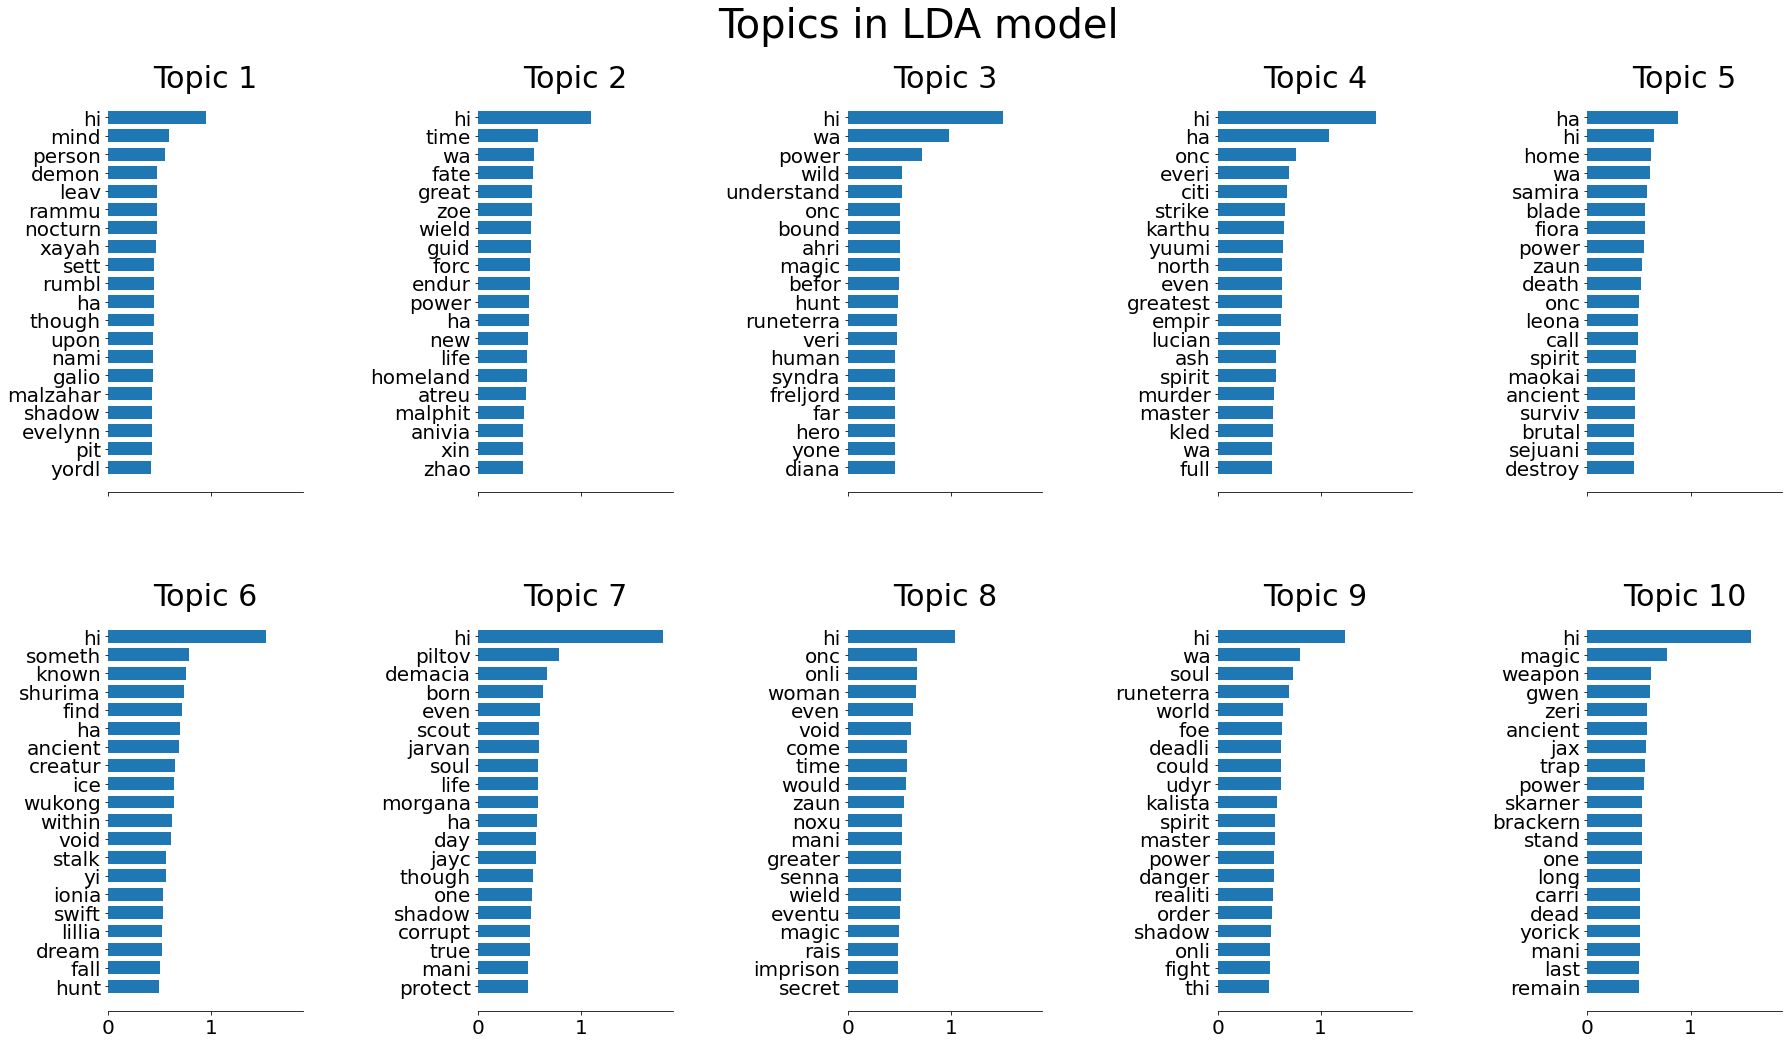

In [376]:
tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, 20, "Topics in LDA model")

# Kmeans

In [377]:
silhouette_coefficients = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

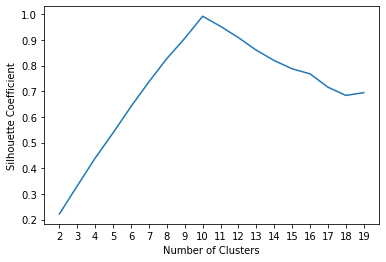

In [378]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [379]:
kmeans = KMeans(n_clusters=10)
df['Grupos'] = kmeans.fit_predict(X)
df

,aatrox,abandon,abil,abl,aboard,abound,abov,abras,absorb,abyss,...,zenith,zeri,zero,zhao,zigg,zilean,zix,zoe,zyra,Grupos
Aatrox,0.350814,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,4
Ahri,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,6
Akali,0.000000,0.167326,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,1
Akshan,0.000000,0.000000,0.0,0.15073,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,5
Alistar,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zeri,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.47419,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,5
Ziggs,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.32911,0.000000,0.0,0.000000,0.000000,7
Zilean,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.00000,0.319939,0.0,0.000000,0.000000,7
Zoe,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.426517,0.000000,8


# ANALISIS DE TOPICS

In [386]:
#Grupos
def nube_estilo(df, n, lista_final):
    palabras = []
    for i in df[df['Grupos'] == n].columns:
        if len(df[df['Grupos'] == n][i].value_counts()) > 2 and len(df[df['Grupos'] == n][i].value_counts()) < 6:
            palabras.append(i)

    indices_0 = df[df['Grupos'] == n][palabras].index

    texto = []
    for i in lista_final:
        if i[0] in indices_0:
            texto.append(nltk.Text(i[1]))

    for i in texto:
        for j in i.tokens:
            if j not in palabras:
                i.tokens.remove(j)

    texto_final = ''
    for i in texto:
        texto_final += ' '.join(i.tokens)
    try:
        remove("stylecloud.png")
        stylecloud.gen_stylecloud(texto_final,
                        icon_name='fas fa-apple-alt',
                        palette='cartocolors.qualitative.Pastel_3',
                        background_color='black',
                        collocations=False)
    except:
        stylecloud.gen_stylecloud(texto_final,
                              icon_name='fas fa-apple-alt',
                             palette='cartocolors.qualitative.Pastel_3',
                              background_color='black',
                              collocations=False)
        




    return Image(filename='stylecloud.png') 

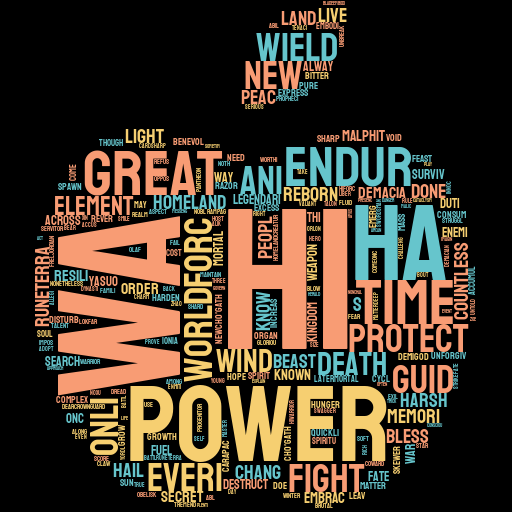

In [393]:
#Con la funcion creada te genera automaticamente un wordcloud con las palabras de cada grupo para el estudio
nube_estilo(df, 8, lista_final)